In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

In [3]:
X = digits["data"]

print(X.shape)
X

(1797, 64)


array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

### Visualize

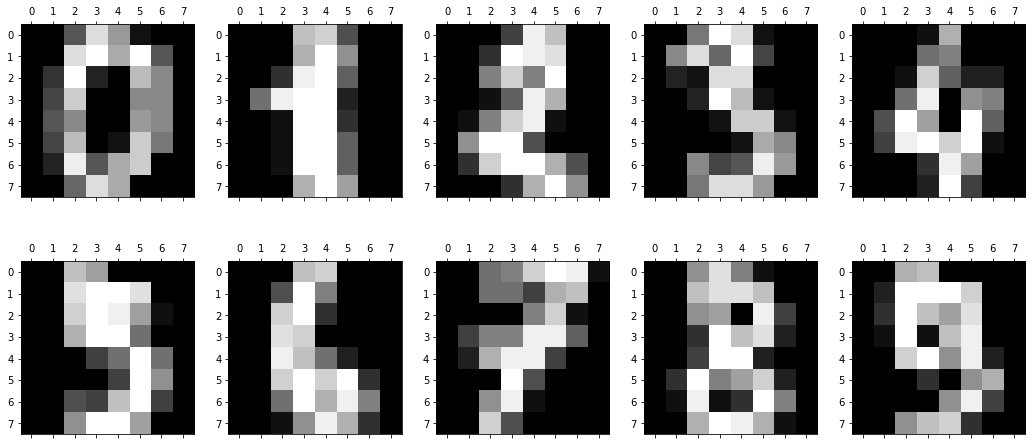

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.gray()

figure, axes = plt.subplots(nrows=2, ncols=5)
figure.set_size_inches(18, 8)

axes[0][0].matshow(X[0].reshape(8, 8))
axes[0][1].matshow(X[1].reshape(8, 8))
axes[0][2].matshow(X[2].reshape(8, 8))
axes[0][3].matshow(X[3].reshape(8, 8))
axes[0][4].matshow(X[4].reshape(8, 8))
axes[1][0].matshow(X[5].reshape(8, 8))
axes[1][1].matshow(X[6].reshape(8, 8))
axes[1][2].matshow(X[7].reshape(8, 8))
axes[1][3].matshow(X[8].reshape(8, 8))
axes[1][4].matshow(X[9].reshape(8, 8))

In [5]:
y = digits["target"]

print(y.shape)
y

(1797,)


array([0, 1, 2, ..., 8, 9, 8])

## Preprocessing

In [6]:
X_mean = X.mean()

X = X - X_mean

X.mean(), X.min(), X.max()

(8.995463126623417e-17, -4.884164579855314, 11.115835420144686)

In [7]:
from keras.utils import to_categorical

y_hot = to_categorical(y)

print(y.shape, y_hot.shape)

C:\Users\BKLEE\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(1797,) (1797, 10)


## Define Activation

### Sigmoid

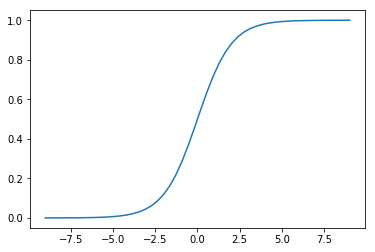

In [8]:
def sigmoid(n):
    return 1 / (1 + np.exp(-n))

xx = np.linspace(start=-9, stop=+9)
yy = sigmoid(xx)

plt.plot(xx, yy)

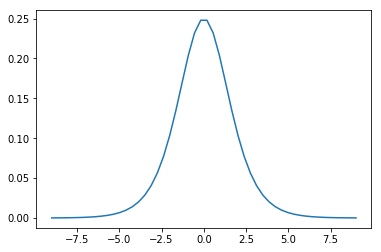

In [9]:
def sigmoid_derivative(n):
    return sigmoid(n) * (1 - sigmoid(n))

xx = np.linspace(start=-9, stop=+9)
yy = sigmoid_derivative(xx)

plt.plot(xx, yy)

## Build a Model

In [10]:
from time import time

def train(X, y, num_epoch, learning_rate, update_method):
    errors = []

    start = time()

    w1 = np.random.uniform(low=-np.sqrt(6 / (64+100)),
                           high=+np.sqrt(6 / (64+100)),
                           size=(64, 100))

    w2 = np.random.uniform(low=-np.sqrt(6 / (100+10)),
                           high=+np.sqrt(6 / (100+10)),
                           size=(100, 10))

    for epoch in range(num_epoch):
        # Forward Propagation
        z1 = X.dot(w1)
        a1 = sigmoid(z1)
        z2 = a1.dot(w2)
        a2 = sigmoid(z2)

        y_predict = np.argmax(a2, axis=1)
        error = (y_predict != y).mean()

        if epoch % (num_epoch // 10) == 0:
            print("{0:3} error = {1:.5f}".format(epoch, error))

        errors.append({
            'epoch': epoch,
            'elapsed': time() - start,
            'error': error,
        })

        # Backpropagation
        d2 = (a2 - y_hot)
        d1 = d2.dot(w2.T) * sigmoid_derivative(z1)

        # Weight gradients
        dw2 = a1.T.dot(d2)
        dw1 = X.T.dot(d1)

        w1, w2 = update_method(epoch, learning_rate, w1, w2, dw1, dw2)

    print("----" * 10)
    print("{0:3} error = {1:.5f}".format(epoch, error))
    
    errors = pd.DataFrame(errors)
    errors = errors[["epoch", "elapsed", "error"]]

    return errors

### Stochastic Gradient Descent

In [11]:
def update_sgd(epoch, learning_rate, w1, w2, dw1, dw2):
    w2 = w2 - learning_rate * dw2
    w1 = w1 - learning_rate * dw1
    
    return w1, w2

num_epoch = 100
learning_rate = 0.0001

errors_sgd = train(X, y, num_epoch, learning_rate, update_method=update_sgd)

errors_sgd.head(10)

  0 error = 0.87813
 10 error = 0.14079
 20 error = 0.08681
 30 error = 0.07012
 40 error = 0.06010
 50 error = 0.05120
 60 error = 0.04452
 70 error = 0.03895
 80 error = 0.03673
 90 error = 0.03228
----------------------------------------
 99 error = 0.02894


,epoch,elapsed,error
0,0,0.026012,0.878130
1,1,0.059034,0.772398
2,2,0.088057,0.641068
3,3,0.118077,0.487479
4,4,0.142093,0.382304
5,5,0.159801,0.304953
6,6,0.191050,0.251530
7,7,0.217052,0.205342
8,8,0.244069,0.180857
9,9,0.270090,0.158598


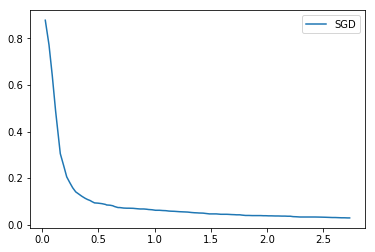

In [12]:
plt.plot(errors_sgd['elapsed'],
         errors_sgd['error'],
         label="SGD")

plt.legend()

### Momentum

In [13]:
# write your code here!

# 보통 mu는 처음에 0.9로 지정

mu = 0.9
cache_dw1, cache_dw2 = 0, 0

def update_momentum(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2
    
    cache_dw2 = mu * cache_dw2 - learning_rate * dw2
    w2 = w2 + cache_dw2
    
    cache_dw1 = mu * cache_dw1 - learning_rate * dw1
    w1 = w1 + cache_dw1
    
    return w1, w2

num_epoch = 100
learning_rate = 0.0001

errors_momentum = train(X, y, num_epoch, learning_rate,
                       update_method = update_momentum)
errors_momentum.head(10)

  0 error = 0.90039
 10 error = 0.47746
 20 error = 0.12855
 30 error = 0.06066
 40 error = 0.03339
 50 error = 0.02226
 60 error = 0.01503
 70 error = 0.01002
 80 error = 0.00668
 90 error = 0.00556
----------------------------------------
 99 error = 0.00556


,epoch,elapsed,error
0,0,0.015012,0.900390
1,1,0.047032,0.887590
2,2,0.070252,0.890373
3,3,0.085877,0.838063
4,4,0.117127,0.792432
5,5,0.132755,0.658319
6,6,0.164004,0.555927
7,7,0.179628,0.549249
8,8,0.195255,0.617140
9,9,0.235092,0.423484


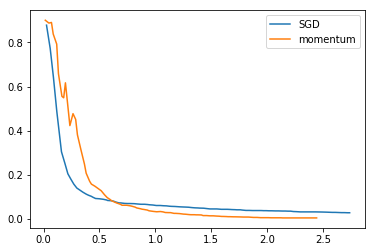

In [14]:
plt.plot(errors_sgd['elapsed'], errors_sgd['error'], label="SGD")
plt.plot(errors_momentum['elapsed'], errors_momentum['error'], label="momentum")

plt.legend()

### Nesterov Momentum

In [15]:
# write your code here!

# write your code here!

# 보통 mu는 처음에 0.9로 지정

mu = 0.9
cache_dw1, cache_dw2 = 0, 0

def update_nesterov(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2
    
    dw2_prev= cache_dw2
    cache_dw2 = mu * cache_dw2 - learning_rate * dw2
    w2 = w2 + (-mu * dw2_prev) + (1+mu) * cache_dw2
    
    dw1_prev= cache_dw1
    cache_dw1 = mu * cache_dw1 - learning_rate * dw1
    w1 = w1 + (-mu * dw1_prev) + (1+mu) * cache_dw1
    
    return w1, w2

num_epoch = 100
learning_rate = 0.0001

errors_nesterov = train(X, y, num_epoch, learning_rate,
                       update_method = update_nesterov)
errors_nesterov.head(10)

  0 error = 0.91208
 10 error = 0.21536
 20 error = 0.07234
 30 error = 0.03840
 40 error = 0.02226
 50 error = 0.01391
 60 error = 0.00890
 70 error = 0.00723
 80 error = 0.00612
 90 error = 0.00501
----------------------------------------
 99 error = 0.00501


,epoch,elapsed,error
0,0,0.010991,0.912076
1,1,0.040011,0.872565
2,2,0.067031,0.808570
3,3,0.093058,0.780189
4,4,0.123070,0.700056
5,5,0.144085,0.499722
6,6,0.168102,0.402894
7,7,0.188786,0.297718
8,8,0.204411,0.224263
9,9,0.236261,0.218141


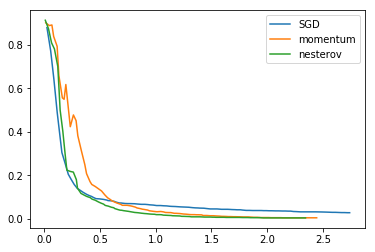

In [16]:
plt.plot(errors_sgd['elapsed'], errors_sgd['error'], label="SGD")
plt.plot(errors_momentum['elapsed'], errors_momentum['error'], label="momentum")
plt.plot(errors_nesterov['elapsed'], errors_nesterov['error'], label="nesterov")

plt.legend()

### AdaGrad

In [19]:
# write your code here!

# 보통 mu는 처음에 0.9로 지정

mu = 0.9
eps = 0.000000001
cache_dw1, cache_dw2 = 0, 0

def update_adagrad(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2
    
    cache_dw2 = cache_dw2 + dw2 ** 2
    w2 = w2 - learning_rate * dw2 / np.sqrt(cache_dw2 + eps)
    
    cache_dw1 = cache_dw1 + dw1 ** 2
    w1 = w1 - learning_rate * dw1 / np.sqrt(cache_dw1 + eps)
    
    return w1, w2

num_epoch = 100
learning_rate = 0.01
#learning_rate가 momentum보다 보통 크다; momentum은 워낙 빠르니까.

errors_adagrad = train(X, y, num_epoch, learning_rate,
                       update_method = update_adagrad)
errors_adagrad.head(10)

  0 error = 0.86867
 10 error = 0.14357
 20 error = 0.10351
 30 error = 0.07123
 40 error = 0.05620
 50 error = 0.05008
 60 error = 0.04508
 70 error = 0.04118
 80 error = 0.03339
 90 error = 0.02838
----------------------------------------
 99 error = 0.02782


,epoch,elapsed,error
0,0,0.010007,0.868670
1,1,0.039028,0.832499
2,2,0.067047,0.683361
3,3,0.096068,0.538119
4,4,0.128092,0.355036
5,5,0.156110,0.259878
6,6,0.178126,0.212020
7,7,0.186249,0.180301
8,8,0.217500,0.157485
9,9,0.244439,0.148024


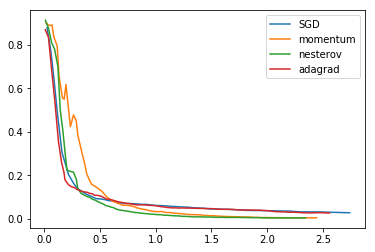

In [20]:
plt.plot(errors_sgd['elapsed'], errors_sgd['error'], label="SGD")
plt.plot(errors_momentum['elapsed'], errors_momentum['error'], label="momentum")
plt.plot(errors_nesterov['elapsed'], errors_nesterov['error'], label="nesterov")
plt.plot(errors_adagrad['elapsed'], errors_adagrad['error'], label="adagrad")
#momentum에 비해 adaptive 방법이 덜 수렴되는 경향이 있긴 하다.

plt.legend()

### RMSProp

In [23]:
# write your code here!

# 보통 mu는 처음에 0.9로 지정

decay = 0.995
eps = 0.000000001
cache_dw1, cache_dw2 = 0, 0

def update_rmsprop(epoch, learning_rate, w1, w2, dw1, dw2):
    global cache_dw1, cache_dw2
    
    cache_dw2 = decay * cache_dw2 + (1-decay) * dw2 ** 2
    w2 = w2 - learning_rate * dw2 / np.sqrt(cache_dw2 + eps)
    
    cache_dw1 = decay * cache_dw1 + (1-decay) * dw1 ** 2
    w1 = w1 - learning_rate * dw1 / np.sqrt(cache_dw1 + eps)
    
    return w1, w2

num_epoch = 100
learning_rate = 0.01
#learning_rate가 momentum보다 보통 크다; momentum은 워낙 빠르니까.

errors_rmsprop = train(X, y, num_epoch, learning_rate,
                       update_method = update_rmsprop)
errors_rmsprop.head(10)

  0 error = 0.96327
 10 error = 0.44073
 20 error = 0.25376
 30 error = 0.13801
 40 error = 0.12799
 50 error = 0.06288
 60 error = 0.05064
 70 error = 0.04563
 80 error = 0.04786
 90 error = 0.02838
----------------------------------------
 99 error = 0.02059


,epoch,elapsed,error
0,0,0.011008,0.963272
1,1,0.037024,0.879800
2,2,0.066048,0.895938
3,3,0.094066,0.903172
4,4,0.120085,0.774624
5,5,0.153109,0.790762
6,6,0.181127,0.775181
7,7,0.209147,0.427379
8,8,0.234166,0.574290
9,9,0.265188,0.324430


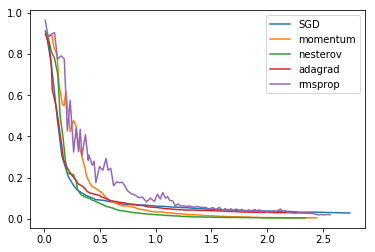

In [24]:
plt.plot(errors_sgd['elapsed'], errors_sgd['error'], label="SGD")
plt.plot(errors_momentum['elapsed'], errors_momentum['error'], label="momentum")
plt.plot(errors_nesterov['elapsed'], errors_nesterov['error'], label="nesterov")
plt.plot(errors_adagrad['elapsed'], errors_adagrad['error'], label="adagrad")
plt.plot(errors_rmsprop['elapsed'], errors_rmsprop['error'], label="rmsprop")
#momentum에 비해 adaptive 방법이 덜 수렴되는 경향이 있긴 하다.

plt.legend()

### Adam

In [29]:
# write your code here!

beta1 = 0.9
beta2 = 0.99

eps = 0.0000001

dw1m, dw2m = 0, 0
dw1v, dw2v = 0, 0

def update_adam(epoch, learning_rate, w1, w2, dw1, dw2):
    global dw1m, dw2m
    global dw1v, dw2v
    
    dw2m = beta1 * dw2m + (1-beta1) * dw2
    dw2v = beta2 * dw2v + (1-beta2) * (dw2 ** 2)
    dw2mb = dw2m / (1 - beta1 ** (1 + epoch))
    dw2vb = dw2v / (1 - beta2 ** (1 + epoch))
    w2 = w2 - learning_rate * dw2mb / np.sqrt(dw2vb + eps)
    
    dw1m = beta1 * dw1m + (1-beta1) * dw1
    dw1v = beta2 * dw1v + (1-beta2) * (dw1 ** 2)
    dw1mb = dw1m / (1 - beta1 ** (1 + epoch))
    dw1vb = dw1v / (1 - beta2 ** (1 + epoch))
    w1 = w1 - learning_rate * dw1mb / np.sqrt(dw1vb + eps)

num_epoch = 100
learning_rate = 0.01
#learning_rate가 momentum보다 보통 크다; momentum은 워낙 빠르니까.

errors_adam = train(X, y, num_epoch, learning_rate,
                       update_method = update_adam)
errors_adam.head(10)

  0 error = 0.91319


TypeError: 'NoneType' object is not iterable